In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib                               import pyplot
import seaborn as sns
%matplotlib inline

from datetime                                 import date
import math

from sklearn.model_selection                  import train_test_split
from sklearn.preprocessing                    import MinMaxScaler
from sklearn.feature_selection                import RFE
from sklearn.linear_model                     import LinearRegression
from sklearn.feature_selection                import RFE
from sklearn.metrics                          import r2_score
from sklearn.metrics                          import mean_squared_error
from sklearn.preprocessing                    import LabelEncoder

import statsmodels.api as sm 
from statsmodels.stats.outliers_influence     import variance_inflation_factor

In [2]:
pd.set_option('display.max_columns', None)

# Reading and Understanding the Data

In [3]:
boombikes = pd.read_csv("day.csv")

In [4]:
boombikes.shape

(730, 16)

In [5]:
boombikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [6]:
# We have to predict cnt based on other factors, so no use of casual and registered columns as we are not predicting those
# No use of column index "instant", so drop it
boombikes = boombikes.drop(['instant', 'casual', 'registered'], axis=1)

In [7]:
# No null values, all columns have correct Dtypes
boombikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  cnt         730 non-null    int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 74.3+ KB


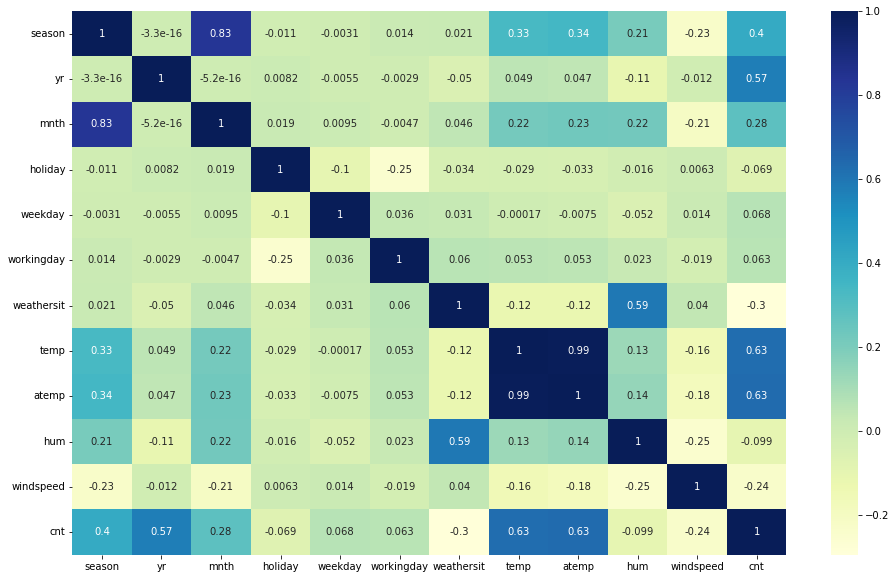

In [8]:
# Check the correlation coefficients to see which variables are highly correlated
plt.figure(figsize = (16, 10))
sns.heatmap(boombikes.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [9]:
# Drop temp as it is highly correlated with atemp, 
# we are keeping atemp as it is a temperature which body feels, which make more sense in this case
boombikes = boombikes.drop(['temp'], axis=1)

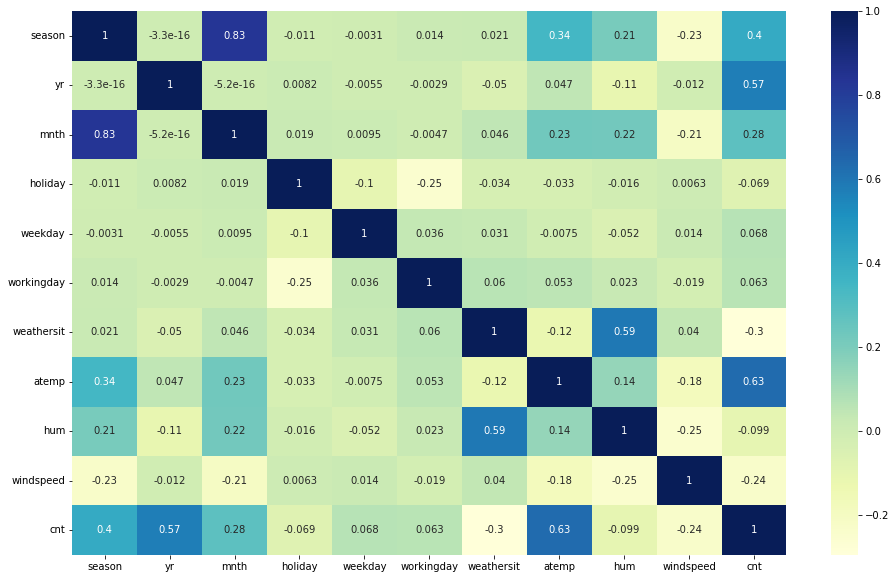

In [10]:
# Check the correlation coefficients to see which variables are highly correlated
plt.figure(figsize = (16, 10))
sns.heatmap(boombikes.corr(), annot = True, cmap="YlGnBu")
plt.show()

### From the correlation coefficients
#### 1) cnt is potitively correlated with season, yr, mnth, atemp and
#### 2) cnt is negatively correlated with weathersit and windspeed
#### 3) season and month highly correlated

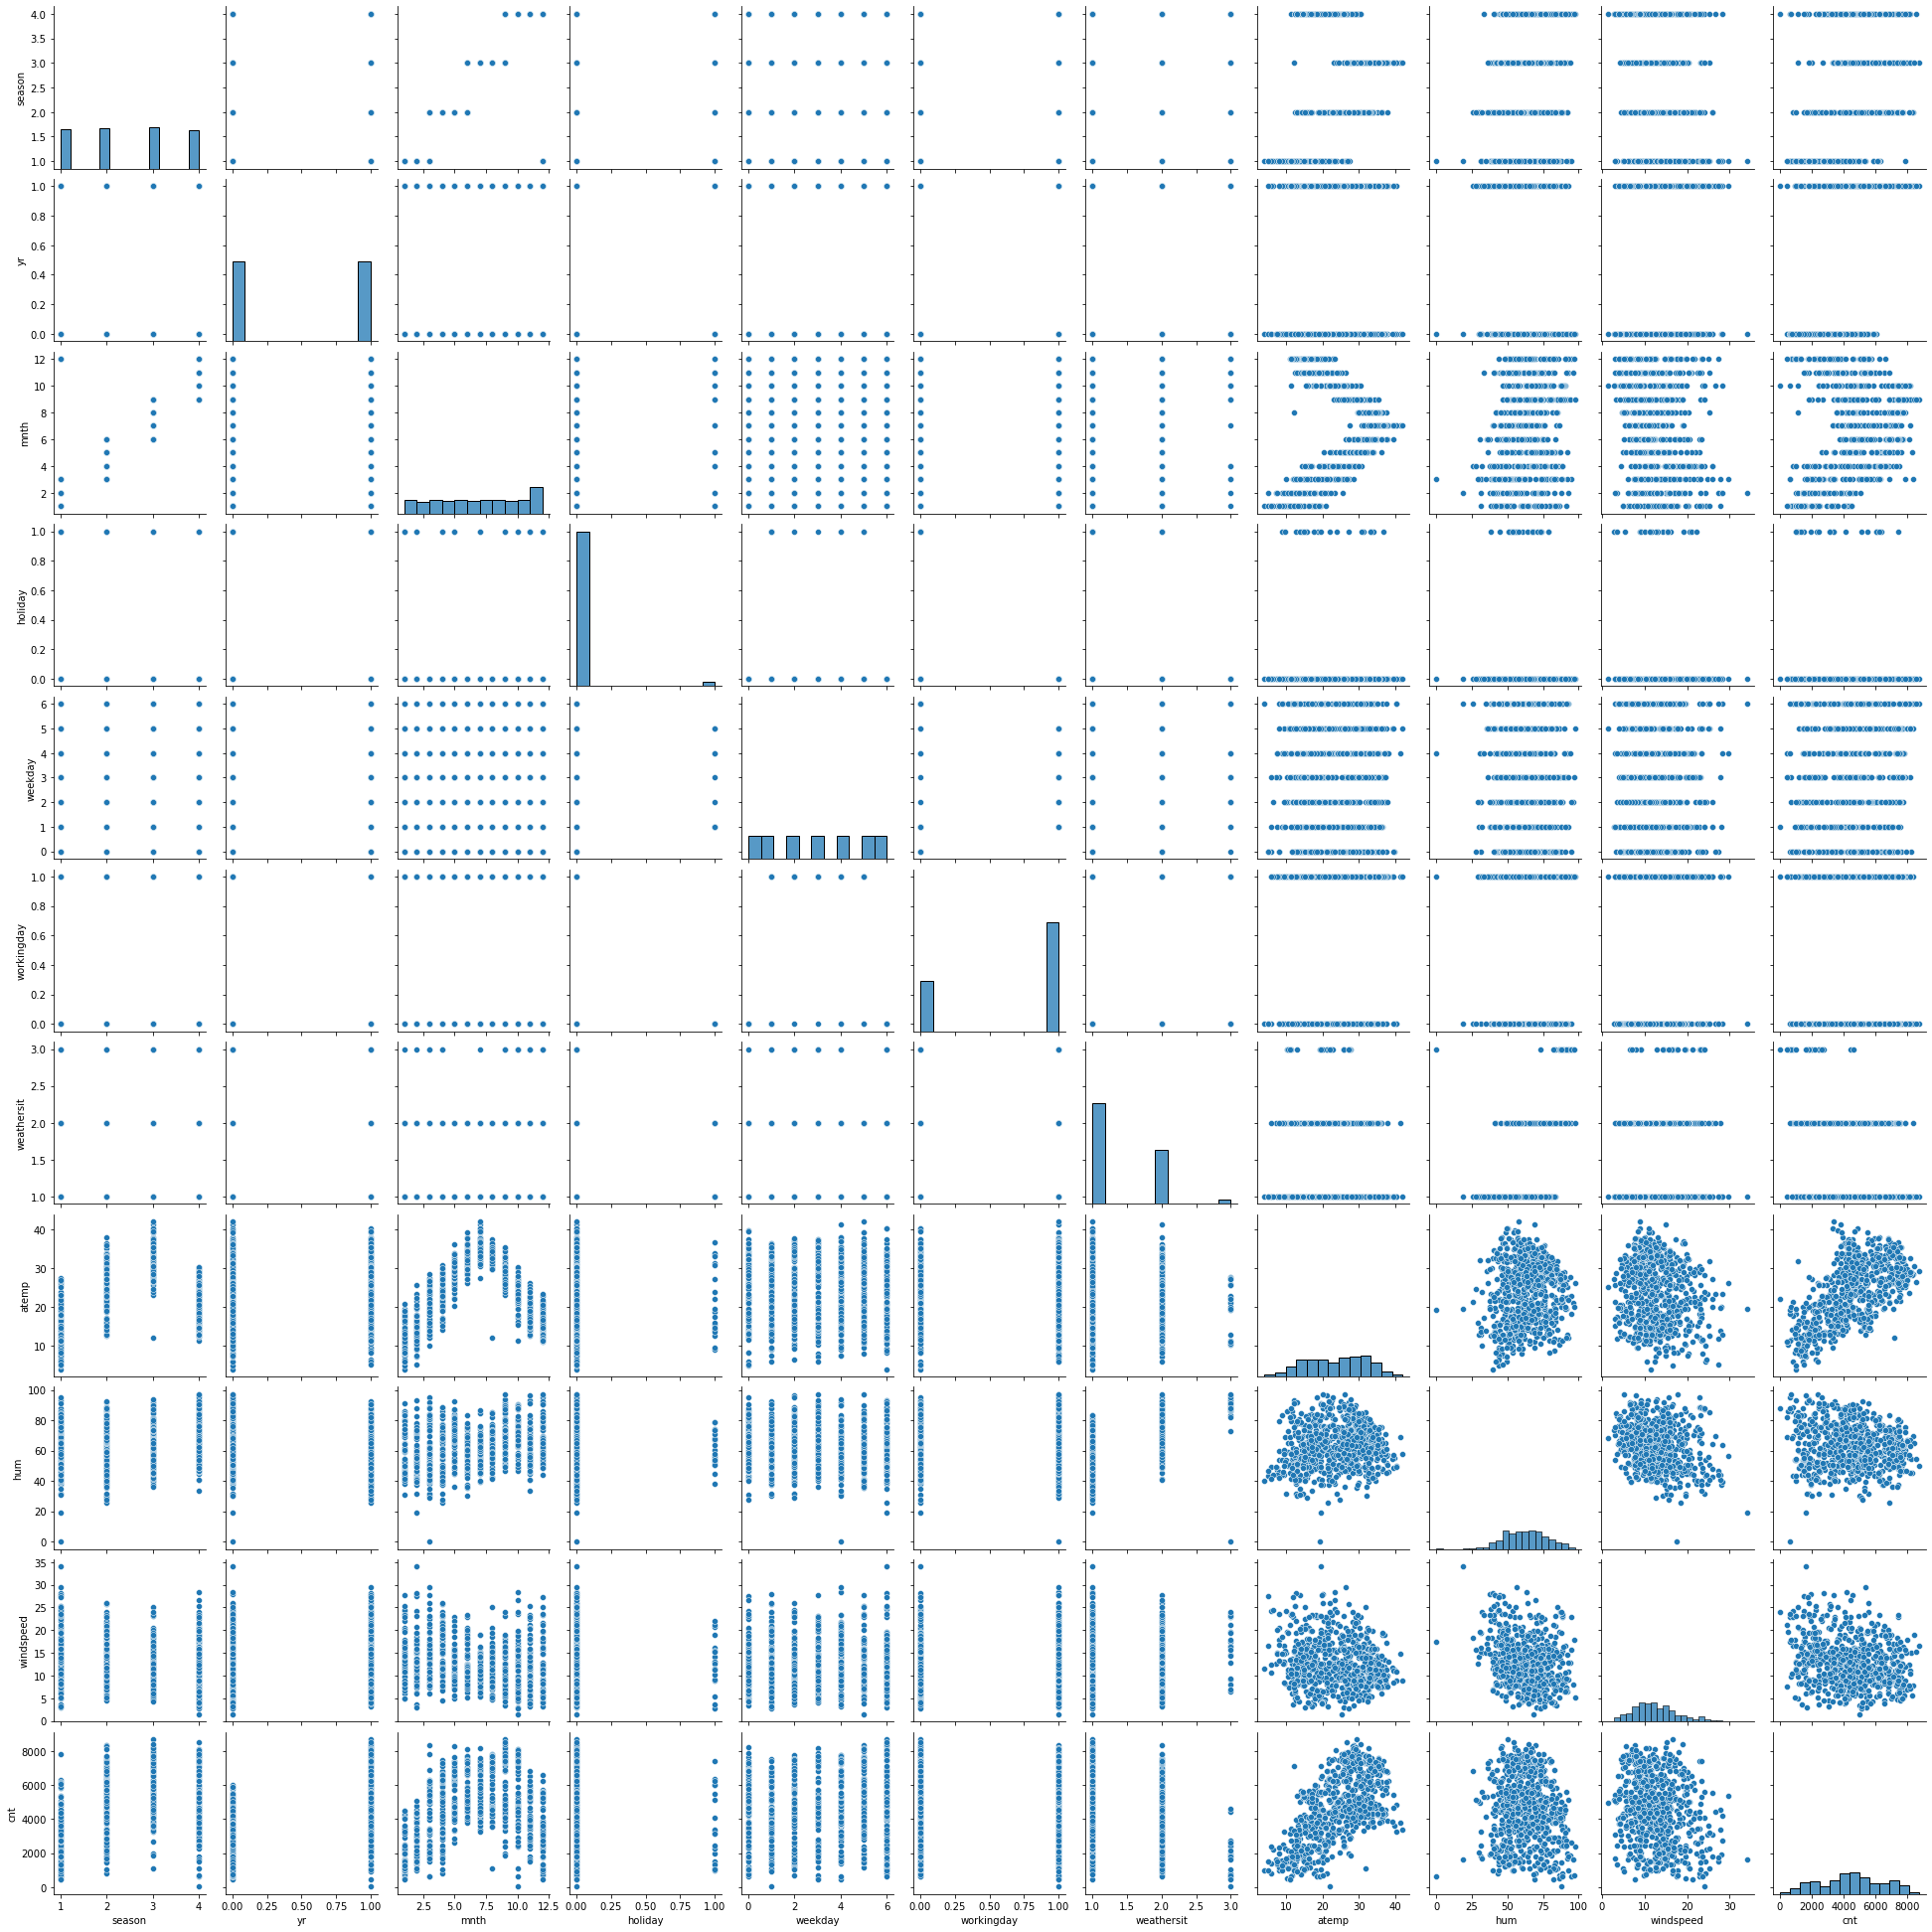

In [11]:
#Visualising Numeric Variables
sns.pairplot(boombikes)
plt.show()

In [12]:
# Update values of the variables as per data dictionary
# Update value for yr columns
year = {0 : 2018, 1: 2019}
boombikes.yr = boombikes.yr.map(year)

In [13]:
# Update value for weathersit column
weather = {1: "Clear", 2: "Mist", 3: "Light Snow"}
boombikes.weathersit = boombikes.weathersit.map(weather)

In [14]:
# Update value for season column
season = {1: "spring", 2: "summer", 3: "fall", 4: "winter"}
boombikes.season = boombikes.season.map(season)

In [15]:
# Update value for mnth column
mnth = {1: "jan", 2: "feb", 3: "mar", 4: "apr", 5: "may", 6:"jun", 7:"jul", 8:"aug", 9:"sept", 10:"oct", 11:"nov", 12:"dec"}
boombikes.mnth = boombikes.mnth.map(mnth)

In [16]:
# Update value for mnth column
weekday = {0: "mon", 1: "tue", 2: "wed", 3: "thu", 4: "fri", 5:"sat", 6:"sun"}
boombikes.weekday = boombikes.weekday.map(weekday)

In [17]:
# Converting date to Pandas datetime format
boombikes['dteday'] = pd.to_datetime(boombikes['dteday'], format='%d-%m-%Y')

In [18]:
#drop dteday column as it make no se
boombikes = boombikes.drop(['dteday'], axis=1)

In [19]:
boombikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
0,spring,2018,jan,0,sun,0,Mist,18.18125,80.5833,10.749882,985
1,spring,2018,jan,0,mon,0,Mist,17.68695,69.6087,16.652113,801
2,spring,2018,jan,0,tue,1,Clear,9.47025,43.7273,16.636703,1349
3,spring,2018,jan,0,wed,1,Clear,10.60610,59.0435,10.739832,1562
4,spring,2018,jan,0,thu,1,Clear,11.46350,43.6957,12.522300,1600


In [20]:
boombikes.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

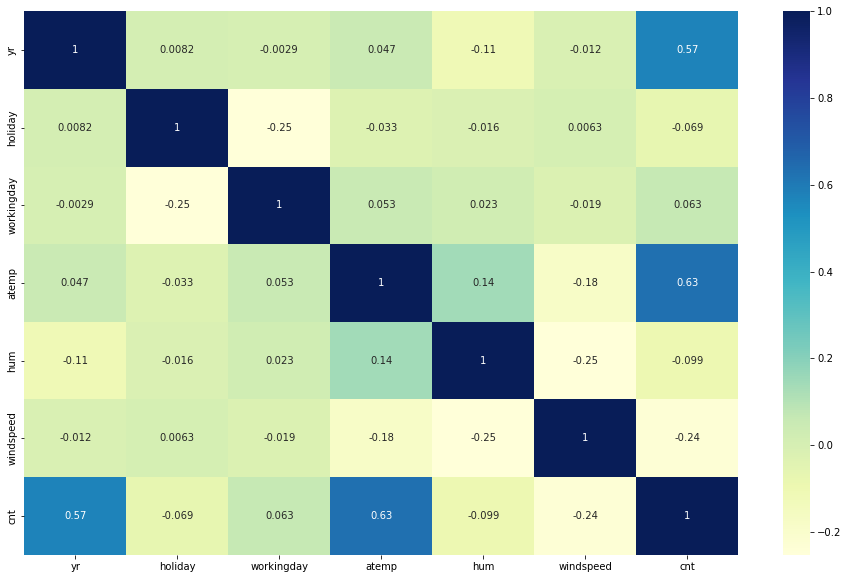

In [21]:
# Check the correlation coefficients to see which variables are highly correlated
plt.figure(figsize = (16, 10))
sns.heatmap(boombikes.corr(), annot = True, cmap="YlGnBu")
plt.show()

# EDA on categorical columns

<AxesSubplot:xlabel='yr', ylabel='cnt'>

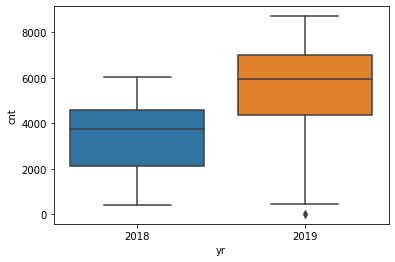

In [22]:
# In year 2019, there were more number of rides as compare to 2018 in each month
sns.boxplot(x = 'yr', y = 'cnt', data = boombikes)

<AxesSubplot:xlabel='mnth', ylabel='cnt'>

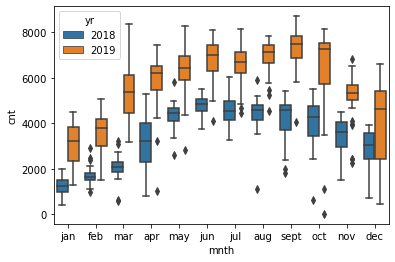

In [23]:
# More rides from May to Oct month for both years
sns.boxplot(x = 'mnth', y = 'cnt', hue='yr', data = boombikes)

<AxesSubplot:xlabel='season', ylabel='cnt'>

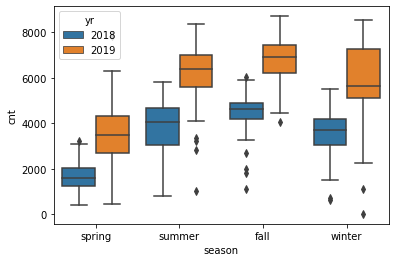

In [24]:
# More rides in summaer and fall season for both years
sns.boxplot(x = 'season', y = 'cnt', hue='yr', data = boombikes)

<AxesSubplot:xlabel='holiday', ylabel='cnt'>

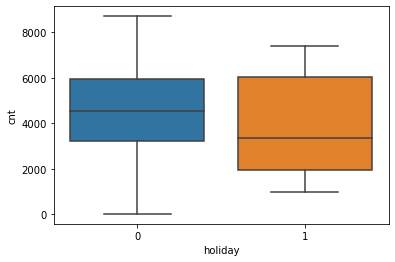

In [25]:
# On holiday median of count of rental bikes is less, so chances of using service is less on holidays
sns.boxplot(x = 'holiday', y = 'cnt', data = boombikes)

<AxesSubplot:xlabel='weekday', ylabel='cnt'>

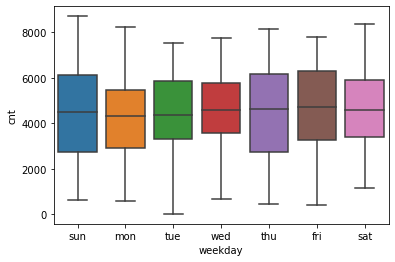

In [26]:
# No visible impact
sns.boxplot(x = 'weekday', y = 'cnt', data = boombikes)

<AxesSubplot:xlabel='workingday', ylabel='cnt'>

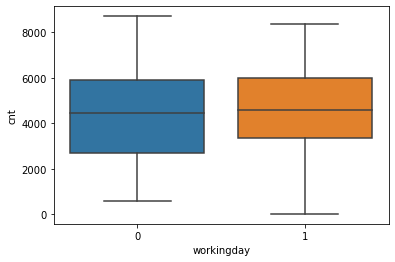

In [27]:
#No visible impact of workingday
sns.boxplot(x = 'workingday', y = 'cnt', data = boombikes)

<AxesSubplot:xlabel='yr'>

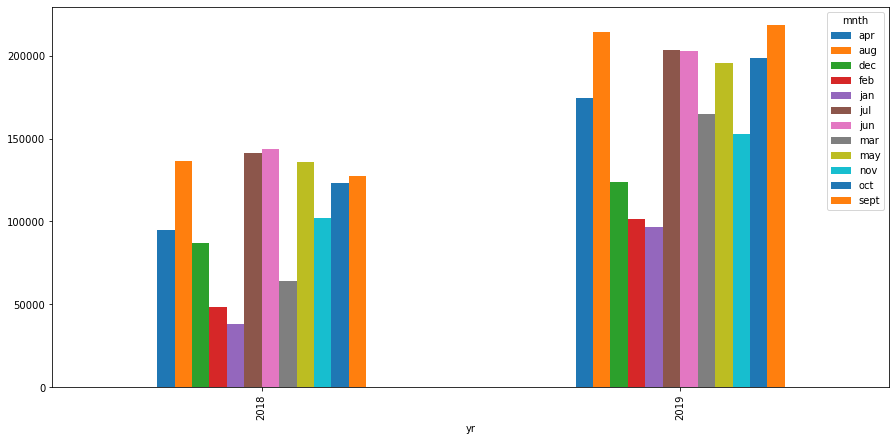

In [28]:
boombikes.pivot_table(index='yr', columns='mnth', values='cnt', aggfunc='sum').plot.bar(figsize=(15,7))
# In both months, more riders from 5 to 10 month

<AxesSubplot:xlabel='weathersit', ylabel='cnt'>

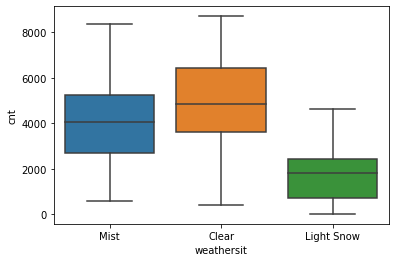

In [29]:
# weathersit=Clear then cnt is high
sns.boxplot(x = 'weathersit', y = 'cnt', data = boombikes)

<AxesSubplot:xlabel='atemp', ylabel='cnt'>

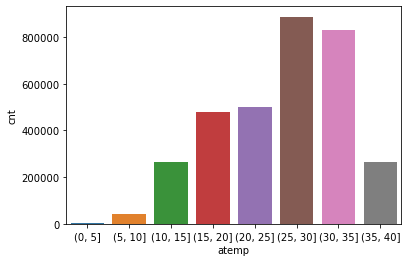

In [30]:
ranges = [0,5,10,15,20,25,30,35,40]
df_atemp = boombikes.groupby([pd.cut(boombikes.atemp, ranges)])[['cnt']].sum()
sns.barplot(df_atemp.index, y='cnt', data=df_atemp)
#Higher rides when atemp in between 25 to 35 

<AxesSubplot:xlabel='hum', ylabel='cnt'>

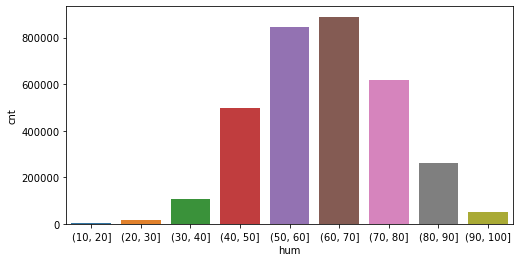

In [31]:
ranges = [10,20,30,40,50,60,70,80,90, 100]
df_hum = boombikes.groupby([pd.cut(boombikes.hum, ranges)])[['cnt']].sum()
plt.figure(figsize=(8,4))
sns.barplot(df_hum.index, y='cnt', data=df_hum)
#For humidity from 40-80, more ride count

<AxesSubplot:xlabel='windspeed', ylabel='cnt'>

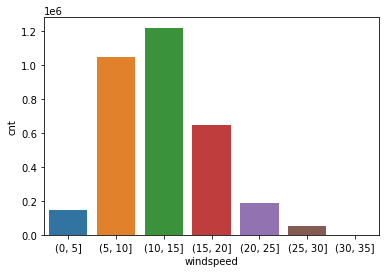

In [32]:
ranges = [0,5,10,15,20,25,30,35]
df_windspeed = boombikes.groupby([pd.cut(boombikes.windspeed, ranges)])[['cnt']].sum()
sns.barplot(df_windspeed.index, y='cnt', data=df_windspeed)
#For windspeed from 5-20, more ride count

In [33]:
boombikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
0,spring,2018,jan,0,sun,0,Mist,18.18125,80.5833,10.749882,985
1,spring,2018,jan,0,mon,0,Mist,17.68695,69.6087,16.652113,801
2,spring,2018,jan,0,tue,1,Clear,9.47025,43.7273,16.636703,1349
3,spring,2018,jan,0,wed,1,Clear,10.60610,59.0435,10.739832,1562
4,spring,2018,jan,0,thu,1,Clear,11.46350,43.6957,12.522300,1600


In [34]:
# yr column does not make any sense in analysis, as in future it will not come again, so dropping it
#boombikes.drop(['yr'], axis = 1, inplace = True)

In [35]:
boombikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
0,spring,2018,jan,0,sun,0,Mist,18.18125,80.5833,10.749882,985
1,spring,2018,jan,0,mon,0,Mist,17.68695,69.6087,16.652113,801
2,spring,2018,jan,0,tue,1,Clear,9.47025,43.7273,16.636703,1349
3,spring,2018,jan,0,wed,1,Clear,10.60610,59.0435,10.739832,1562
4,spring,2018,jan,0,thu,1,Clear,11.46350,43.6957,12.522300,1600


In [36]:
#Create dummies for season
season = pd.get_dummies(boombikes['season'], drop_first = True)
# Add the results to the original boombikes dataframe
boombikes = pd.concat([boombikes, season], axis = 1)

In [37]:
#Create dummies for mnth
mnth = pd.get_dummies(boombikes['mnth'], drop_first = True)
# Add the results to the original boombikes dataframe
boombikes = pd.concat([boombikes, mnth], axis = 1)

In [38]:
#Create dummies for weekday
weekday = pd.get_dummies(boombikes['weekday'], drop_first = True)
# Add the results to the original boombikes dataframe
boombikes = pd.concat([boombikes, weekday], axis = 1)

In [39]:
#Create dummies for weathersit
weathersit = pd.get_dummies(boombikes['weathersit'], drop_first = True)
# Add the results to the original boombikes dataframe
boombikes = pd.concat([boombikes, weathersit], axis = 1)

In [40]:
boombikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt,spring,summer,winter,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sept,mon,sat,sun,thu,tue,wed,Light Snow,Mist
0,spring,2018,jan,0,sun,0,Mist,18.18125,80.5833,10.749882,985,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,spring,2018,jan,0,mon,0,Mist,17.68695,69.6087,16.652113,801,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,spring,2018,jan,0,tue,1,Clear,9.47025,43.7273,16.636703,1349,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,spring,2018,jan,0,wed,1,Clear,10.60610,59.0435,10.739832,1562,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,spring,2018,jan,0,thu,1,Clear,11.46350,43.6957,12.522300,1600,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [41]:
# Drop 'season' as we have created the dummies for it
boombikes.drop(['season'], axis = 1, inplace = True)
# Drop 'mnth' as we have created the dummies for it
boombikes.drop(['mnth'], axis = 1, inplace = True)
# Drop 'weekday' as we have created the dummies for it
boombikes.drop(['weekday'], axis = 1, inplace = True)
# Drop 'weathersit' as we have created the dummies for it
boombikes.drop(['weathersit'], axis = 1, inplace = True)

In [42]:
boombikes.head()

,yr,holiday,workingday,atemp,hum,windspeed,cnt,spring,summer,winter,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sept,mon,sat,sun,thu,tue,wed,Light Snow,Mist
0,2018,0,0,18.18125,80.5833,10.749882,985,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,2018,0,0,17.68695,69.6087,16.652113,801,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,2018,0,1,9.47025,43.7273,16.636703,1349,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2018,0,1,10.60610,59.0435,10.739832,1562,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,2018,0,1,11.46350,43.6957,12.522300,1600,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [43]:
boombikes.columns

Index(['yr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'cnt',
       'spring', 'summer', 'winter', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun',
       'mar', 'may', 'nov', 'oct', 'sept', 'mon', 'sat', 'sun', 'thu', 'tue',
       'wed', 'Light Snow', 'Mist'],
      dtype='object')

In [44]:
# Reordering the columns
columns = ['yr','holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'spring',
       'summer', 'winter', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar',
       'may', 'nov', 'oct', 'sept', 'mon', 'sat', 'sun', 'thu', 'tue', 'wed',
       'Light Snow', 'Mist', 'cnt']
boombikes = boombikes[columns]

In [45]:
boombikes.head()

,yr,holiday,workingday,atemp,hum,windspeed,spring,summer,winter,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sept,mon,sat,sun,thu,tue,wed,Light Snow,Mist,cnt
0,2018,0,0,18.18125,80.5833,10.749882,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,985
1,2018,0,0,17.68695,69.6087,16.652113,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,801
2,2018,0,1,9.47025,43.7273,16.636703,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1349
3,2018,0,1,10.60610,59.0435,10.739832,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1562
4,2018,0,1,11.46350,43.6957,12.522300,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1600


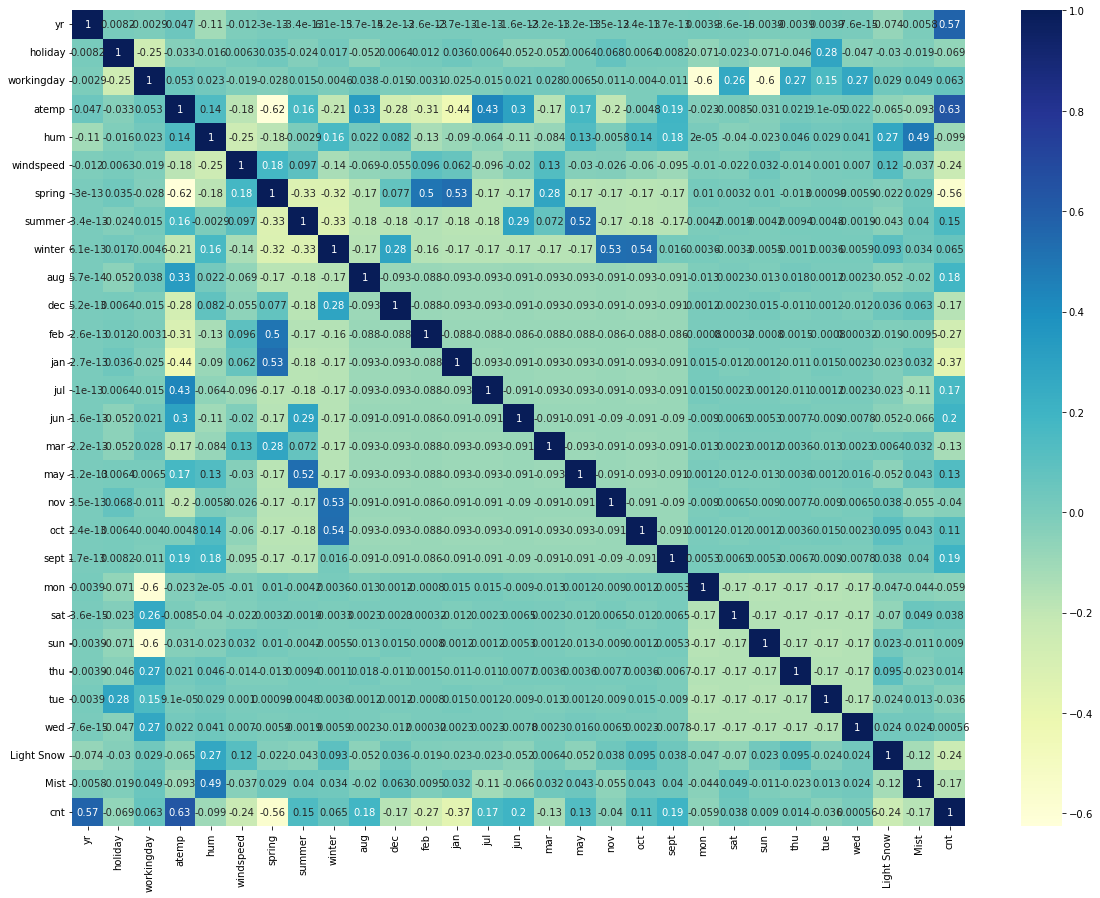

In [46]:
# Let's check the correlation coefficients to see which variables are highly correlated
plt.figure(figsize = (20, 15))
sns.heatmap(boombikes.corr(), annot = True, cmap="YlGnBu")
plt.show()

# Training the model

## Test-train split and scaling

In [47]:
# We specify seed so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(boombikes, train_size = 0.7, test_size = 0.3, random_state = 100)

In [48]:
df_train.shape, df_test.shape

((510, 29), (219, 29))

In [49]:
df_train.columns

Index(['yr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'spring',
       'summer', 'winter', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar',
       'may', 'nov', 'oct', 'sept', 'mon', 'sat', 'sun', 'thu', 'tue', 'wed',
       'Light Snow', 'Mist', 'cnt'],
      dtype='object')

In [50]:
#Min-Max scaling (Normalization): Between 0 and 1
scaler = MinMaxScaler()
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['yr', 'atemp', 'hum', 'windspeed', 'cnt']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [51]:
df_train.head()

,yr,holiday,workingday,atemp,hum,windspeed,spring,summer,winter,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sept,mon,sat,sun,thu,tue,wed,Light Snow,Mist,cnt
653,1.0,0,1,0.501133,0.575354,0.300794,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0.864243
576,1.0,0,1,0.766351,0.725633,0.264686,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.827658
426,1.0,0,0,0.438975,0.640189,0.255342,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0.465255
728,1.0,0,0,0.200348,0.498067,0.663106,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.204096
482,1.0,0,0,0.391735,0.504508,0.188475,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0.482973


In [52]:
df_train[num_vars].describe()

,yr,atemp,hum,windspeed,cnt
count,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.512989,0.650369,0.320768,0.513620
std,0.500429,0.212385,0.145882,0.169797,0.224593
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.332086,0.538643,0.199179,0.356420
50%,1.000000,0.526811,0.653714,0.296763,0.518638
75%,1.000000,0.688457,0.754830,0.414447,0.684710
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [53]:
df_train.describe()

,yr,holiday,workingday,atemp,hum,windspeed,spring,summer,winter,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sept,mon,sat,sun,thu,tue,wed,Light Snow,Mist,cnt
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.00000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.512989,0.650369,0.320768,0.243137,0.245098,0.24902,0.096078,0.084314,0.066667,0.088235,0.076471,0.074510,0.098039,0.084314,0.086275,0.086275,0.080392,0.143137,0.127451,0.154902,0.158824,0.150980,0.131373,0.029412,0.343137,0.513620
std,0.500429,0.157763,0.468282,0.212385,0.145882,0.169797,0.429398,0.430568,0.43287,0.294988,0.278131,0.249689,0.283915,0.266010,0.262857,0.297660,0.278131,0.281045,0.281045,0.272166,0.350557,0.333805,0.362166,0.365870,0.358381,0.338139,0.169124,0.475223,0.224593
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.332086,0.538643,0.199179,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.356420
50%,1.000000,0.000000,1.000000,0.526811,0.653714,0.296763,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.518638
75%,1.000000,0.000000,1.000000,0.688457,0.754830,0.414447,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.684710
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Building the model - Considering all the variables to the model

In [54]:
y_train = df_train.pop('cnt')
X_train = df_train

In [55]:
#Build a linear model
X_train_lm = sm.add_constant(X_train)

lr = sm.OLS(y_train, X_train_lm)
lr_model = lr.fit()
# Check the summary
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     101.9
Date:                Mon, 11 Apr 2022   Prob (F-statistic):          4.12e-180
Time:                        19:06:07   Log-Likelihood:                 523.84
No. Observations:                 510   AIC:                            -991.7
Df Residuals:                     482   BIC:                            -873.1
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2564      0.035      7.283      0.0

In [56]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,workingday,84.83
22,sun,19.34
20,mon,18.01
6,spring,10.74
8,winter,9.47
7,summer,8.23
17,nov,6.77
18,oct,6.59
9,aug,6.24
3,atemp,5.95


## Feature Selection using RFE

In [57]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [58]:
rfe = RFE(linreg, n_features_to_select=8) 
rfe = rfe.fit(X_train, y_train)

In [59]:
rfe.support_

array([ True,  True, False,  True,  True,  True,  True, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False])

In [60]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 9),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', False, 12),
 ('winter', False, 4),
 ('aug', False, 13),
 ('dec', False, 7),
 ('feb', False, 10),
 ('jan', False, 5),
 ('jul', True, 1),
 ('jun', False, 14),
 ('mar', False, 20),
 ('may', False, 11),
 ('nov', False, 6),
 ('oct', False, 21),
 ('sept', False, 3),
 ('mon', False, 15),
 ('sat', False, 18),
 ('sun', False, 8),
 ('thu', False, 19),
 ('tue', False, 16),
 ('wed', False, 17),
 ('Light Snow', True, 1),
 ('Mist', False, 2)]

In [61]:
col = X_train.columns[rfe.support_]

In [62]:
X_train.columns[~rfe.support_]

Index(['workingday', 'summer', 'winter', 'aug', 'dec', 'feb', 'jan', 'jun',
       'mar', 'may', 'nov', 'oct', 'sept', 'mon', 'sat', 'sun', 'thu', 'tue',
       'wed', 'Mist'],
      dtype='object')

In [63]:
#Build a linear model
X_train_lm = sm.add_constant(X_train[col])

lr = sm.OLS(y_train, X_train_lm)
lr_model = lr.fit()
# Check the summary
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     276.6
Date:                Mon, 11 Apr 2022   Prob (F-statistic):          2.34e-178
Time:                        19:06:08   Log-Likelihood:                 469.32
No. Observations:                 510   AIC:                            -920.6
Df Residuals:                     501   BIC:                            -882.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4256      0.030     14.237      0.0

In [64]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,11.01
2,atemp,10.65
4,windspeed,3.85
0,yr,2.03
5,spring,1.80
6,jul,1.34
7,Light Snow,1.11
1,holiday,1.03


In [65]:
col

Index(['yr', 'holiday', 'atemp', 'hum', 'windspeed', 'spring', 'jul',
       'Light Snow'],
      dtype='object')

In [66]:
# Dropping hum as VIF > 5
col = ['yr', 'holiday', 'atemp', 'windspeed', 'spring', 'jul', 'Light Snow']

In [67]:
#Build a linear model
X_train_lm = sm.add_constant(X_train[col])

lr = sm.OLS(y_train, X_train_lm)
lr_model = lr.fit()
# Check the summary
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     276.9
Date:                Mon, 11 Apr 2022   Prob (F-statistic):          7.50e-168
Time:                        19:06:08   Log-Likelihood:                 441.71
No. Observations:                 510   AIC:                            -867.4
Df Residuals:                     502   BIC:                            -833.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2543      0.021     12.348      0.0

In [68]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,atemp,3.86
3,windspeed,3.66
0,yr,2.03
4,spring,1.49
5,jul,1.25
6,Light Snow,1.05
1,holiday,1.03


## Feature importance

In [69]:
col

['yr', 'holiday', 'atemp', 'windspeed', 'spring', 'jul', 'Light Snow']

Feature: 0, Score: 0.23646
Feature: 1, Score: -0.07209
Feature: 2, Score: 0.45098
Feature: 3, Score: -0.13636
Feature: 4, Score: -0.14083
Feature: 5, Score: -0.06867
Feature: 6, Score: -0.23996


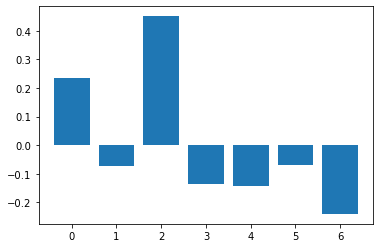

In [70]:
linreg = LinearRegression()
linreg.fit(X_train[col], y_train)
# get importance
importance = linreg.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### Feature with higher importance are
#### atemp, Light Snow - weathersit, yr, spring - season

# Verification of linear regression assumptions

In [71]:
y_train_pred = lr_model.predict(X_train_lm)

Text(0.5, 0, 'Errors')

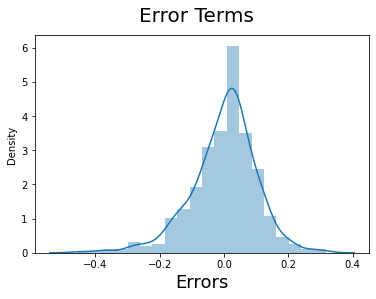

In [72]:
# Plot the histogram of the error terms
fig = plt.figure()
residual = y_train - y_train_pred
sns.distplot(residual, bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

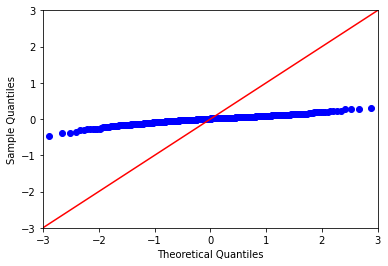

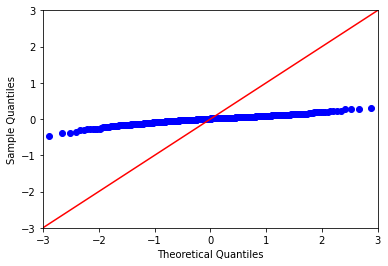

In [73]:
# QQ-plot
sm.qqplot(residual, line ='45')

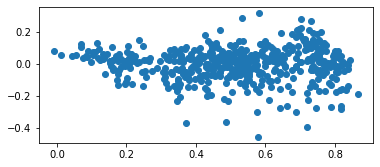

In [74]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_train_pred, residual)

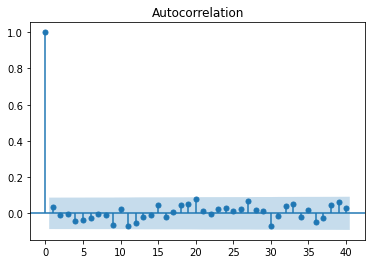

In [75]:
acf = sm.graphics.tsa.plot_acf(residual, lags=40, alpha=0.05)
acf.show()

# Making Predictions on test data using the Model

In [76]:
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [77]:
df_test.head()

,yr,holiday,workingday,atemp,hum,windspeed,spring,summer,winter,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sept,mon,sat,sun,thu,tue,wed,Light Snow,Mist,cnt
184,0.0,1,0,0.769660,0.657364,0.084219,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.692706
535,1.0,0,1,0.842587,0.610133,0.153728,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0.712034
299,0.0,0,1,0.496145,0.837699,0.334206,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0.303382
221,0.0,0,1,0.795343,0.437098,0.339570,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.547400
152,0.0,0,1,0.741471,0.314298,0.537414,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.569029


In [78]:
df_test.describe()

,yr,holiday,workingday,atemp,hum,windspeed,spring,summer,winter,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sept,mon,sat,sun,thu,tue,wed,Light Snow,Mist,cnt
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.479452,0.036530,0.698630,0.532991,0.638508,0.313350,0.255708,0.264840,0.232877,0.059361,0.086758,0.100457,0.077626,0.105023,0.095890,0.054795,0.086758,0.073059,0.082192,0.086758,0.146119,0.178082,0.118721,0.100457,0.127854,0.164384,0.027397,0.319635,0.520592
std,0.500722,0.188034,0.459904,0.217888,0.148974,0.159947,0.437258,0.442259,0.423633,0.236840,0.282125,0.301297,0.268194,0.307285,0.295115,0.228100,0.282125,0.260830,0.275286,0.282125,0.354034,0.383458,0.324202,0.301297,0.334692,0.371472,0.163612,0.467403,0.218435
min,0.000000,0.000000,0.000000,0.025950,0.261915,-0.042808,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048205
25%,0.000000,0.000000,0.000000,0.344751,0.527265,0.198517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.377531
50%,0.000000,0.000000,1.000000,0.549198,0.627737,0.299459,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524275
75%,1.000000,0.000000,1.000000,0.714132,0.743928,0.403048,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.672745
max,1.000000,1.000000,1.000000,0.980934,1.002146,0.807474,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.963300


In [79]:
# Dividing into X_test and y_test
y_test = df_test.pop('cnt')
X_test = df_test[col]

In [80]:
X_test_lm = sm.add_constant(X_test)

In [81]:
X_test_lm.head()

,const,yr,holiday,atemp,windspeed,spring,jul,Light Snow
184,1.0,0.0,1,0.769660,0.084219,0,1,0
535,1.0,1.0,0,0.842587,0.153728,0,0,0
299,1.0,0.0,0,0.496145,0.334206,0,0,0
221,1.0,0.0,0,0.795343,0.339570,0,0,0
152,1.0,0.0,0,0.741471,0.537414,0,0,0


In [82]:
# Making predictions using the model
y_test_pred = lr_model.predict(X_test_lm)

### r2-score

In [83]:
# evaluation r2-score
r2_score(y_true=y_test, y_pred=y_test_pred)

0.7848771807072111

In [84]:
# evaluation mean_squared_error
mean_squared_error(y_true=y_test, y_pred=y_test_pred)

0.010217432153878377

# Model evaluation on test data

Text(0, 0.5, 'y_pred')

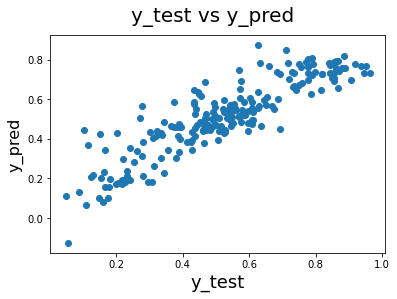

In [85]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16) 